In [71]:
import nibabel as nib
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import glob
from tensorflow.keras.utils import to_categorical
from tifffile import imwrite
import tensorflow as tf


In [72]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler()

Intensity Normalization using Min-Max Scaling
Each image modality (T2, T1ce, FLAIR) is independently scaled to a 0–1 range using Min-Max normalization. This helps standardize the intensity range across scans and accounts for variability between subjects and scanners.

The segmentation mask is loaded and the label 4 (Enhancing Tumor) is remapped to 3 to keep labels in the range [0, 1, 2, 3].

The region is cropped to a centered sub-volume of size 128×128×128, matching typical patch sizes used in 3D CNNs.




In [73]:
TRAIN_DATASET_PATH = r'C:\Users\arnav\Downloads\brain\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData'
scaler = StandardScaler()

# We want to scale all the images so that pizel value is between 0 and 1 

# Load and scale FLAIR image
file_path = os.path.join(TRAIN_DATASET_PATH, 'BraTS20_Training_355', 'BraTS20_Training_355_flair.nii')
test_image_flair = nib.load(file_path).get_fdata()
print(test_image_flair.max())

test_image_flair = scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

# Load and scale T1 image
file_path = os.path.join(TRAIN_DATASET_PATH, 'BraTS20_Training_355', 'BraTS20_Training_355_t1.nii')
test_image_t1 = nib.load(file_path).get_fdata()
test_image_t1 = scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

# Load and scale T1ce image
file_path = os.path.join(TRAIN_DATASET_PATH, 'BraTS20_Training_355', 'BraTS20_Training_355_t1ce.nii')
test_image_t1ce = nib.load(file_path).get_fdata()
test_image_t1ce = scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

# Load and scale T2 image
file_path = os.path.join(TRAIN_DATASET_PATH, 'BraTS20_Training_355', 'BraTS20_Training_355_t2.nii')
test_image_t2 = nib.load(file_path).get_fdata()
test_image_t2 = scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

# Load and process segmentation mask
file_path = os.path.join(TRAIN_DATASET_PATH, 'BraTS20_Training_355', 'BraTS20_Training_355_seg.nii')
test_mask = nib.load(file_path).get_fdata()
test_mask = test_mask.astype(np.uint8)

print(np.unique(test_mask))  # should print [0, 1, 2, 4]
test_mask[test_mask == 4] = 3  # re-encode 4 to 3
print(np.unique(test_mask))  # should now print [0, 1, 2, 3]

1854.603271484375
[0 1 2 4]
[0 1 2 3]


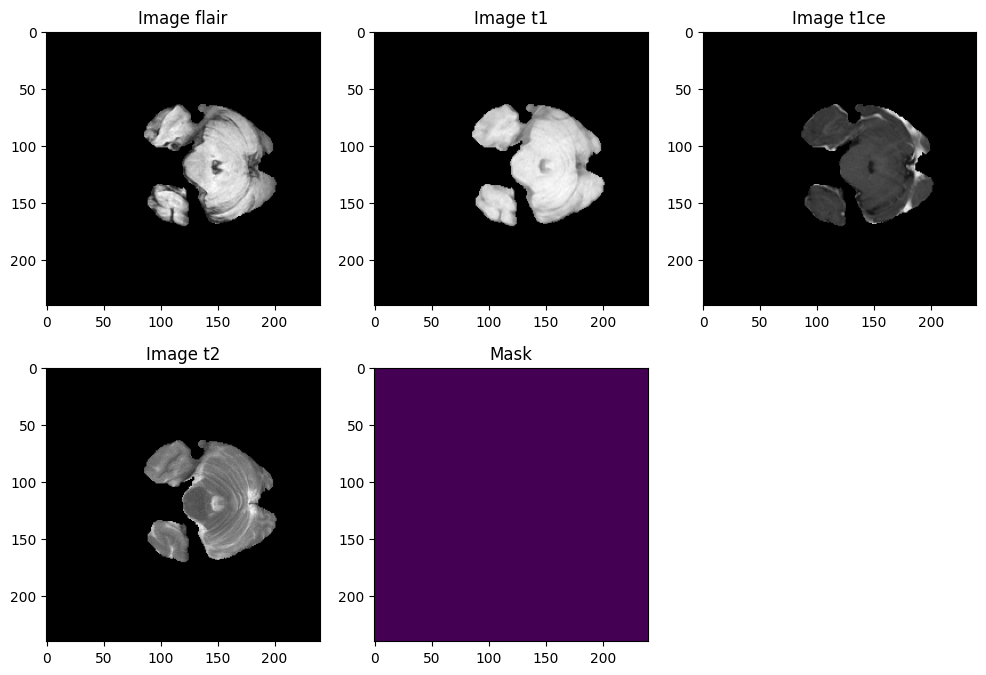

In [74]:
import random
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [75]:
combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)

#Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
#cropping x, y, and z
combined_x=combined_x[56:184, 56:184, 13:141] 
#Crop to 128x128x128x4

#Do the same for mask
test_mask = test_mask[56:184, 56:184, 13:141]

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

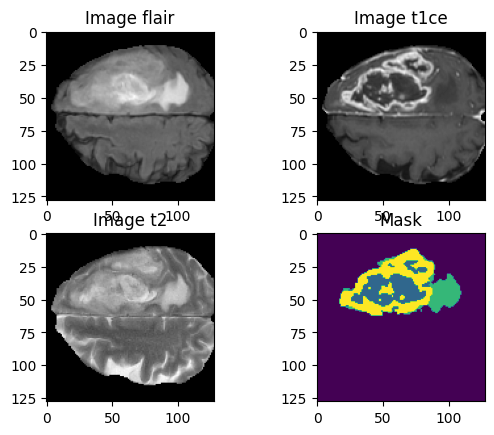

In [76]:
plt.subplot(221)
plt.imshow(combined_x[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(combined_x[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(combined_x[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()


-Tumor in FLAIR and T2 images is demonstrated with a higher intensity thant other parts of the brain

-Tumor is much brighter in T1ce than FLAIR and T2 images (therefore a bigger value for binarization i.e 0.9)

-We'll apply extra constraints to the binarized T1ce images

In [49]:
folder = 'BraTS2020_TrainingData'
if not os.path.exists(folder):
    os.makedirs(folder)

imwrite(os.path.join(folder, 'combined255.tif'), combined_x)
np.save(os.path.join(folder, 'combined255.npy'), combined_x)

# Load the numpy array back to verify
my_img = np.load('BraTS2020_TrainingData/combined255.npy')

print(f"Loaded image shape: {my_img.shape}")
print(f"Loaded image dtype: {my_img.dtype}")
print(f"Max pixel value: {my_img.max()}")
print(f"Min pixel value: {my_img.min()}")

# Convert test_mask to one-hot categorical format for 4 classes
test_mask_cat = to_categorical(test_mask, num_classes=4)
print(f"One-hot encoded mask shape: {test_mask_cat.shape}")

Loaded image shape: (128, 128, 128, 3)
Loaded image dtype: float64
Max pixel value: 31.99657249922522
Min pixel value: -0.5793210196797013
One-hot encoded mask shape: (128, 128, 128, 4, 4)


In [56]:
imwrite('BraTS2020_TrainingData/combined255.tif', combined_x)
np.save('BraTS2020_TrainingData/combined255.npy', combined_x)
#Verify image is being read properly

my_img=np.load('BraTS2020_TrainingData/combined255.npy')

test_mask = to_categorical(test_mask, num_classes=4)

In [69]:
base_path = r'C:\Users\arnav\Downloads\brain\BraTS2020_TrainingData'

# Get sorted lists of each modality and the segmentation mask
t2_list = sorted(glob.glob(base_path + r'\**\*t2.nii', recursive=True))
t1ce_list = sorted(glob.glob(base_path + r'\**\*t1ce.nii', recursive=True))
flair_list = sorted(glob.glob(base_path + r'\**\*flair.nii', recursive=True))
mask_list = sorted(glob.glob(base_path + r'\**\*seg.nii', recursive=True))

print("Number of T2 files found:", len(t2_list))
print("Number of T1ce files found:", len(t1ce_list))
print("Number of Flair files found:", len(flair_list))
print("Number of Mask files found:", len(mask_list))

Number of T2 files found: 369
Number of T1ce files found: 369
Number of Flair files found: 369
Number of Mask files found: 369


In [68]:
output_image_dir = 'C:/Users/arnav/Downloads/brain/BraTS2020_TrainingData/input_data_3channels/images'
output_mask_dir = 'C:/Users/arnav/Downloads/brain/BraTS2020_TrainingData/input_data_3channels/masks'

os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)

Tumor Region Identification:
Although not explicitly segmented in this stage, the code focuses on retaining slices where the tumor (non-zero labels) occupies more than 1% of the volume

In [70]:
output_images_dir = os.path.join(base_path, 'input_data_3channels', 'images')
output_masks_dir = os.path.join(base_path, 'input_data_3channels', 'masks')

os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_masks_dir, exist_ok=True)

# Initialize scaler
scaler = MinMaxScaler()

for img in range(len(t2_list)):  # All lists are the same length
    print("Now preparing image and masks number:", img)

    # Load and scale each image modality
    temp_image_t2 = nib.load(t2_list[img]).get_fdata()
    temp_image_t2 = scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)

    temp_image_t1ce = nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce = scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)

    temp_image_flair = nib.load(flair_list[img]).get_fdata()
    temp_image_flair = scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)

    # Load and clean the mask
    temp_mask = nib.load(mask_list[img]).get_fdata().astype(np.uint8)
    temp_mask[temp_mask == 4] = 3  # Reassign label 4 to 3

    # Stack image channels: [Flair, T1ce, T2]
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)

    # Crop to (128, 128, 128) from center: [56:184, 56:184, 13:141]
    temp_combined_images = temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]

    # Only keep samples with at least 1% non-background (non-zero) label
    val, counts = np.unique(temp_mask, return_counts=True)
    if (1 - (counts[0] / counts.sum())) > 0.01:
        print("Save Me")
        temp_mask = to_categorical(temp_mask, num_classes=4)

        # Save to .npy files
        np.save(os.path.join(output_images_dir, f'image_{img}.npy'), temp_combined_images)
        np.save(os.path.join(output_masks_dir, f'mask_{img}.npy'), temp_mask)
    else:
        print("I am useless")

Now preparing image and masks number: 0
Save Me
Now preparing image and masks number: 1
Save Me
Now preparing image and masks number: 2
Save Me
Now preparing image and masks number: 3
Save Me
Now preparing image and masks number: 4
I am useless
Now preparing image and masks number: 5
Save Me
Now preparing image and masks number: 6
Save Me
Now preparing image and masks number: 7
Save Me
Now preparing image and masks number: 8
Save Me
Now preparing image and masks number: 9
Save Me
Now preparing image and masks number: 10
Save Me
Now preparing image and masks number: 11
Save Me
Now preparing image and masks number: 12
Save Me
Now preparing image and masks number: 13
Save Me
Now preparing image and masks number: 14
Save Me
Now preparing image and masks number: 15
Save Me
Now preparing image and masks number: 16
Save Me
Now preparing image and masks number: 17
Save Me
Now preparing image and masks number: 18
Save Me
Now preparing image and masks number: 19
Save Me
Now preparing image and m

Channel Stacking
The normalized modalities are stacked along a new axis to form a multi-channel 3D input:

Channels used: FLAIR, T1ce, T2 (in that order).

This 3-channel input represents structural and pathological information relevant to brain tumor detection.

Saving Cleaned Data

Final inputs and masks are saved as .npy files in:

images/image_<index>.npy — shape (128, 128, 128, 3)

masks/mask_<index>.npy — shape (128, 128, 128, 4) (one-hot encoded for 4 classes)


In [1]:
import splitfolders

input_folder = r'C:/Users/arnav/Downloads/brain/BraTS2020_TrainingData/input_data_3channels/'
output_folder = r'C:/Users/arnav/Downloads/brain/BraTS2020_TrainingData/input_data_128/'

# Split the data with 75% training and 25% validation
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None)


Copying files: 688 files [02:10,  5.26 files/s]
